<a href="https://colab.research.google.com/github/maab2198/natural_images_classifier/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import zipfile
from keras.utils.np_utils import to_categorical

from keras import layers
from keras.layers import Input, Add, Dense, Activation,Dropout,MaxPool2D, Flatten, Conv2D, AveragePooling2D,SeparableConv2D,GaussianNoise, LocallyConnected2D,LeakyReLU, BatchNormalization
from keras.layers import GRU, Bidirectional
from keras.initializers import RandomUniform, RandomNormal, TruncatedNormal
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.backend import random_normal

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from keras.preprocessing import image as keras_image
from keras.utils import np_utils

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d prasunroy/natural-images
from shutil import unpack_archive
unpack_archive('natural-images.zip', '')

 97% 166M/171M [00:03<00:00, 60.1MB/s]
100% 171M/171M [00:03<00:00, 52.6MB/s]


In [0]:
labels = ['airplane','car','cat','dog','flower','fruit','motorbike','person']
img_size =32

In [0]:
def load_data():
  X,Y = list(), pd.Series()
  k = 0
  data_path = 'natural_images/'
  dirs = os.listdir(data_path)
  dirs.sort()


  for d in dirs:
    new_path = os.path.join(data_path,d)
    files = os.listdir(new_path)
    for f in files:
       if f.endswith(".jpg"):
        read_img = cv2.imread(os.path.join(new_path,f))
        img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(img_size,img_size))
        X.append(img)
        Y = Y.append(pd.Series([k]))
    k+=1

  X = np.array(X)


  Y = to_categorical(Y, 8)
  Y_y = Y
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,stratify=Y)
  X_train , X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1,stratify=Y_train)

  X_train=X_train.reshape((X_train.shape[0],1,X_train.shape[1],X_train.shape[2], X_train.shape[3]))
  X_val=X_val.reshape((X_val.shape[0],1,X_val.shape[1],X_val.shape[2], X_val.shape[3]))
  X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1], X_test.shape[2], X_test.shape[3]))
  return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [0]:

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()
Y_val.shape


(621, 8)

In [0]:
# X_train=X_train.reshape((X_train.shape[0],1,X_train.shape[1],X_train.shape[2], X_train.shape[3]))
# X_val=X_val.reshape((X_val.shape[0],1,X_val.shape[1],X_val.shape[2], X_val.shape[3]))
# X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1], X_test.shape[2], X_test.shape[3]))

print([X_train.shape,Y_train.shape,X_val.shape,Y_val.shape])

[(5588, 1, 32, 32, 3), (5588, 8), (621, 1, 32, 32, 3), (621, 8)]


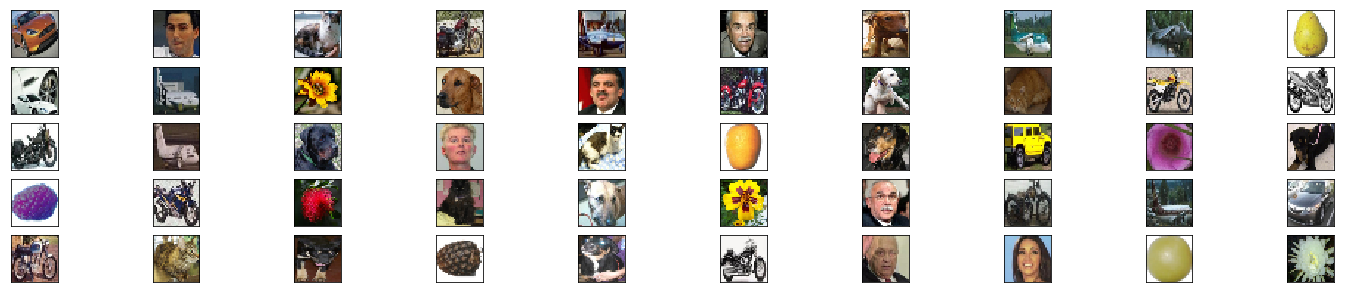

In [0]:
fig = plt.figure(figsize=(25,5))
for i in range(50):
    ax = fig.add_subplot(5,10,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

In [0]:

from keras.layers import SimpleRNN,ConvLSTM2D,GRU, AveragePooling2D
from keras.optimizers import RMSprop
from keras.initializers import Identity
from keras.callbacks import ModelCheckpoint
def my_model():
  print(X_train.shape[1:])
  init_w = RandomUniform(minval=-0.05, maxval=0.05, seed=1)
  rnn = Sequential()

  rnn.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                       activation='tanh',
                       return_sequences=True,
                       padding='same',
                       input_shape=(None,32, 32, 3)))

  rnn.add(BatchNormalization())
  rnn.add(Dropout(0.25))
  rnn.add(ConvLSTM2D(64, (3, 3), activation='tanh'))
  rnn.add(MaxPool2D(pool_size=(2, 2)))
  rnn.add(Dropout(0.5))
  rnn.add(Flatten())
  rnn.add(Dense(64, activation='relu', kernel_initializer=init_w, bias_initializer=init_w))

  rnn.add(Dense(units=8, activation='softmax',
                        kernel_initializer=init_w, bias_initializer=init_w))
  rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return rnn

rnn = my_model()
rnn.summary()
  


(1, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 32, 32, 32)  40448     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 32, 32, 32)  128       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32, 32, 32)  0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 30, 30, 64)        221440    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0     

In [0]:
print([X_train.shape,Y_train.shape,X_val.shape,Y_val.shape])
rnn_history = rnn.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_val, Y_val))

[(5588, 1, 32, 32, 3), (5588, 8), (621, 1, 32, 32, 3), (621, 8)]
Train on 5588 samples, validate on 621 samples
Epoch 1/40
5588/5588 [==============================] - 271s 49ms/step - loss: 0.8001 - acc: 0.7221 - val_loss: 0.7346 - val_acc: 0.7069
Epoch 2/40
5588/5588 [==============================] - 267s 48ms/step - loss: 0.3530 - acc: 0.8640 - val_loss: 1.4613 - val_acc: 0.5620
Epoch 3/40
5588/5588 [==============================] - 267s 48ms/step - loss: 0.2423 - acc: 0.9086 - val_loss: 0.7318 - val_acc: 0.7858
Epoch 4/40
5588/5588 [==============================] - 268s 48ms/step - loss: 0.1996 - acc: 0.9223 - val_loss: 0.5074 - val_acc: 0.8196
Epoch 5/40
5588/5588 [==============================] - 269s 48ms/step - loss: 0.1522 - acc: 0.9433 - val_loss: 0.7575 - val_acc: 0.7649
Epoch 6/40
5588/5588 [==============================] - 270s 48ms/step - loss: 0.1288 - acc: 0.9508 - val_loss: 0.5481 - val_acc: 0.8390
Epoch 7/40
5588/5588 [==============================] - 268s 48ms/

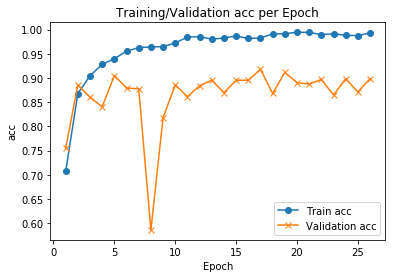

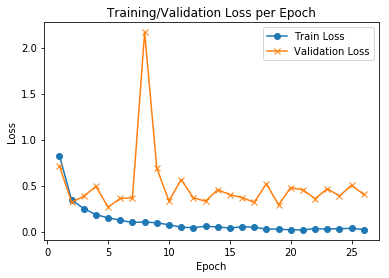

In [0]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['acc'], 'o-')
ax.plot([None] + rnn_history.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc') 

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['loss'], 'o-')
ax.plot([None] + rnn_history.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 
rnn.save("modelCNN.h5")

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
     
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [0]:
loss, accuracy = rnn.evaluate(X_test, Y_test, verbose=0)

print("Accuracy: %.2f%%" % (accuracy*100))
np.set_printoptions(precision=2)

Y_pred = rnn.predict(X_test, batch_size=64, verbose=1)
Y_pred_class = np.argmax(Y_pred, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)
plot_confusion_matrix(Y_test_class, Y_pred_class, classes=labels,
                      title='Confusion matrix')
plt.show()

In [0]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()
X_train=X_train.reshape((X_train.shape[0],-1, X_train.shape[3]))
X_val=X_val.reshape((X_val.shape[0],-1, X_val.shape[3]))
X_test=X_test.reshape((X_test.shape[0],-1, X_test.shape[3]))

In [0]:
print(X_val.shape)
print(Y_val.shape)


(621, 32, 96)
(621, 8)


In [0]:
from keras.layers import LSTM
def my_model2():  
  model = Sequential()
  model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(Y_train.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
  return model
rnn_lstm = my_model2()
rnn_lstm.summary()
rnn_history = rnn_lstm.fit(X_train, Y_train, epochs=60, batch_size=128, verbose=1,validation_data=(X_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 520       
Total params: 60,184
Trainable params: 60,184
Non-trainable params: 0
_________________________________________________________________
Train on 5588 samples, validate on 621 samples
Epoch 1/60
5588/5588 [==============================] - 15s 3ms/step - loss: 2.0366 - acc: 0.2076 - val_loss: 1.8675 - val_acc: 0.3639
Epoch 2/60
5588/5588 [==============================] - 12s 2ms/step - loss: 1.8637 - ac

In [0]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['acc'], 'o-')
ax.plot([None] + rnn_history.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc') 

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['loss'], 'o-')
ax.plot([None] + rnn_history.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 


Accuracy: 66.67%
690/690 [==============================] - 1s 2ms/step


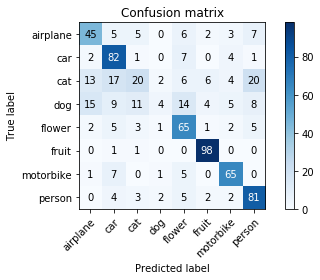

In [0]:
loss, accuracy = rnn_lstm.evaluate(X_test, Y_test, verbose=0)

print("Accuracy: %.2f%%" % (accuracy*100))
np.set_printoptions(precision=2)

Y_pred = rnn_lstm.predict(X_test, batch_size=64, verbose=1)
Y_pred_class = np.argmax(Y_pred, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)
plot_confusion_matrix(Y_test_class, Y_pred_class, classes=labels,
                      title='Confusion matrix')
plt.show()

In [0]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()
X_train=X_train.reshape(-1,32,32*3)
X_val=X_val.reshape(-1,32,32*3)
X_test=X_test.reshape(-1,32,32*3)

In [0]:
print(X_val.shape)
print(Y_val.shape)
# Y_val = Y_val.reshape(-1, 1)
# Y_val.shape
size = 32

(1863, 32, 32)
(621, 8)


(4968, 1)

In [0]:

def simple_rnn(size,class_n):
    model = Sequential()
    model.add(Bidirectional(GRU(units=32,
                                activation='relu',
                                use_bias=True,
                                dropout=0.0,
                                recurrent_dropout=0.1,
                                return_sequences=True),
                            merge_mode='sum',
                            input_shape=( size, size)))
    model.add(GRU(units=32,
                  activation='relu',
                  use_bias=True,
                  dropout=0.2,
                  recurrent_dropout=0.1,
                  return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(class_n))
    model.add(Activation('softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model


In [0]:
rnn_simple = simple_rnn(32,8)
rnn_history = rnn_simple.fit(X_train, Y_train, epochs=30, batch_size=64, verbose=1,validation_data=(X_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_24 (Bidirectio (None, 32, 32)            24768     
_________________________________________________________________
gru_48 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 264       
_________________________________________________________________
activation_30 (Activation)   (None, 8)                 0         
Total params: 31,272
Trainable params: 31,272
Non-trainable params: 0
_________________________________________________________________
Train on 5588 samples, validate on 621 samples
Epoch 1/30
5588/5588 [==============================] - 27s 5ms/step - loss: 13.6639 - acc:

Text(0, 0.5, 'Loss')

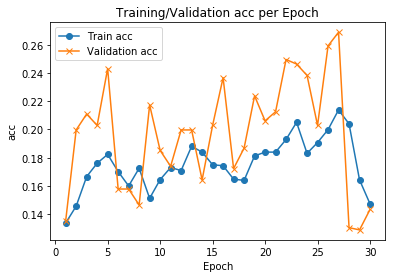

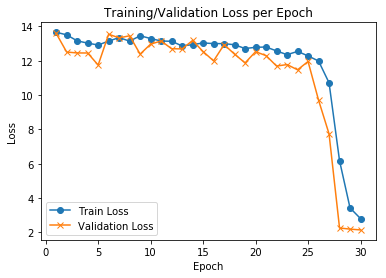

In [0]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['acc'], 'o-')
ax.plot([None] + rnn_history.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc') 

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['loss'], 'o-')
ax.plot([None] + rnn_history.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 

Accuracy: 14.20%
690/690 [==============================] - 0s 528us/step


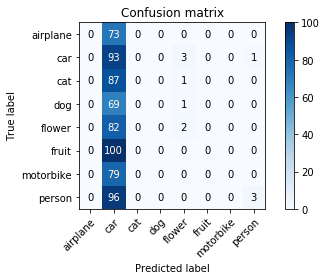

In [0]:
loss, accuracy =rnn_simple.evaluate(X_test, Y_test, verbose=0)

print("Accuracy: %.2f%%" % (accuracy*100))
np.set_printoptions(precision=2)

Y_pred = rnn_simple.predict(X_test, batch_size=64, verbose=1)
Y_pred_class = np.argmax(Y_pred, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)
plot_confusion_matrix(Y_test_class, Y_pred_class, classes=labels,
                      title='Confusion matrix')
plt.show()

In [0]:
def remove_class(x_data, y_data, class_index):
  import numpy as np
  
  x_data_to_keep = []
  y_data_to_keep = []
  
  for i in range(len(y_data)):
    if y_data[i] != class_index:
      x_data_to_keep.append(x_data[i])
      y_data_to_keep.append(y_data[i])
      
      
  x_data = np.array(x_data_to_keep)
  y_data = np.array(y_data_to_keep)
  
  return x_data, y_data

def load_fashion_mnist():

	from keras.datasets import fashion_mnist
	((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

	x_train, y_train = remove_class(x_train, y_train, 1)
	x_test, y_test = remove_class(x_test, y_test, 1)


	return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_fashion_mnist()
x_train, y_train = data_reshape_cnn(x_train, y_train)

x_train = x_train.astype('float32') / 255.0

x_test, y_test = data_reshape_cnn(x_test, y_test)
x_test = x_test.astype('float32') / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

labels = ['top', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 
          'sneaker', 'bag', 'boot']

In [0]:
def data_reshape(x, y):
	

  
  x = x.reshape(-1, 28, 28)
  y = y.reshape(-1, 1)
  
  return x, y

In [0]:



size=28
model = simple_rnn(size,10);

rnn_history = model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1,validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 28, 32)            11712     
_________________________________________________________________
gru_52 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_32 (Activation)   (None, 10)                0         
Total params: 18,282
Trainable params: 18,282
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 9000 samples
Epoch 1/5
54000/54000 [==============================] - 114s 2ms/step - loss: 1.0972 - a

Text(0, 0.5, 'Loss')

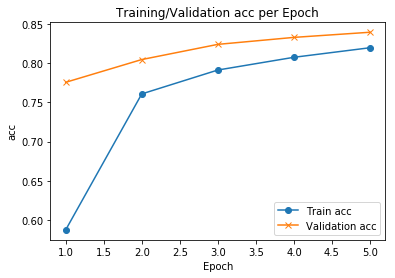

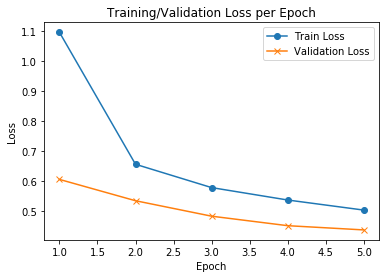

In [0]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['acc'], 'o-')
ax.plot([None] + rnn_history.history['val_acc'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc') 

f, ax = plt.subplots()
ax.plot([None] + rnn_history.history['loss'], 'o-')
ax.plot([None] + rnn_history.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 

Accuracy: 83.92%
9000/9000 [==============================] - 4s 413us/step


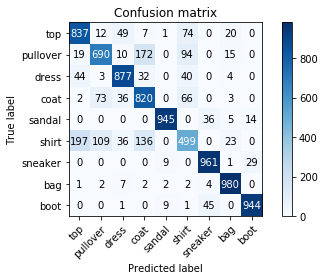

In [0]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print("Accuracy: %.2f%%" % (accuracy*100))
np.set_printoptions(precision=2)

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_class, y_pred_class, classes=labels,
                      title='Confusion matrix')
plt.show()

In [0]:
def data_reshape_cnn(train, test):
  train = train.reshape((train.shape[0], 28, 28, 1))
  test = test.reshape((test.shape[0], 28, 28, 1))
  return train, test

In [0]:
x_train, y_train, x_test, y_test = load_fashion_mnist()
x_train, y_train = data_reshape(x_train, y_train)

x_train = x_train.astype('float32') / 255.0

x_test, y_test = data_reshape(x_test, y_test)
x_test = x_test.astype('float32') / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

labels = ['top', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 
          'sneaker', 'bag', 'boot']

In [0]:
def le_net():
    model = Sequential()

    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5), 
                     strides=(1, 1), 
                     padding='valid',
                     activation='tanh', 
                     input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     strides=(1, 1),
                     padding='valid', 
                     activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax'))
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, decay=1e-6),
                  metrics=['accuracy'])
    return model
model_cnn = le_net()
model.summary()


[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 28, 32)            11712     
_________________________________________________________________
gru_52 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_32 (Activation)   (None, 10)                0         
Total params: 18,282
Trainable params: 18,282
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1,validation_data=(x_test, y_test))

Train on 54000 samples, validate on 9000 samples
Epoch 1/5
54000/54000 [==============================] - 107s 2ms/step - loss: 0.4814 - acc: 0.8259 - val_loss: 0.4345 - val_acc: 0.8386
Epoch 2/5
54000/54000 [==============================] - 98s 2ms/step - loss: 0.4672 - acc: 0.8302 - val_loss: 0.4045 - val_acc: 0.8487
Epoch 3/5
54000/54000 [==============================] - 90s 2ms/step - loss: 0.4496 - acc: 0.8376 - val_loss: 0.3915 - val_acc: 0.8557
Epoch 4/5
54000/54000 [==============================] - 45s 836us/step - loss: 0.4424 - acc: 0.8391 - val_loss: 0.3876 - val_acc: 0.8554
Epoch 5/5
54000/54000 [==============================] - 45s 837us/step - loss: 0.4297 - acc: 0.8434 - val_loss: 0.3805 - val_acc: 0.8580


Accuracy: 85.80%
9000/9000 [==============================] - 2s 185us/step


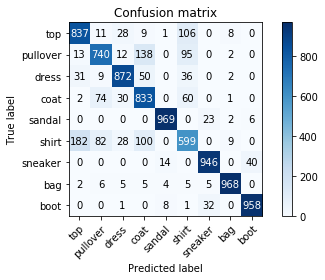

In [0]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print("Accuracy: %.2f%%" % (accuracy*100))
np.set_printoptions(precision=2)

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_class, y_pred_class, classes=labels,
                      title='Confusion matrix')